In [40]:
import torch
from torchvision.io import read_image
from torch import nn
import torch.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torchvision.models.swin_transformer as swin
from torchsummary import summary
import matplotlib.pyplot as plt
from torch import autograd
from torch import optim
from tqdm import tqdm
import timm
import os
from torch.utils.tensorboard import SummaryWriter

In [13]:
# device setup
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [14]:
#base path for dataset
BASE_PATH_Noisy = r"/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V4/noisy/"
BASE_PATH_Clean = r"/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V4/clean/"

In [15]:
#Dataframe importing
dataframe = pd.read_csv("/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V4/metadata.csv")

### Creating a Dataset and Dataloader

In [16]:
# Transform
transform = nn.Sequential(
    transforms.Resize((224,224))
)

In [17]:
# Dataset
class ImageNoiseDataset(Dataset):
    def __init__(self, data:pd.DataFrame, transform:transforms =None):
        super().__init__()
        self.data = data.Path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        raw_img = read_image(BASE_PATH_Noisy + item)/255.0
        raw_clean_img = read_image(BASE_PATH_Clean+item)/255.0
        if self.transform:
            noisy_img = self.transform(raw_img)
            clean_img = self.transform(raw_clean_img)
        else:
            noisy_img = raw_img
            clean_img = raw_clean_img
        return noisy_img, clean_img

In [18]:
#Train and test dataframe
train_df = dataframe.sample(frac=0.8, random_state=42)
test_df = dataframe.drop(train_df.index)

#Creating Dataset
train_dataset = ImageNoiseDataset(train_df,transform=transform)
test_dataset = ImageNoiseDataset(test_df, transform=transform)

#Creating Dataloader
train_dl = DataLoader(train_dataset, batch_size=2, num_workers=0, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=2, num_workers=0, shuffle=True)

### Model Architecture 1

In [19]:
# Downsampling block
class DownSample(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=output_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.LeakyReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)
    
# Upsampling block
class UpSample(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=output_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.LeakyReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)

In [20]:
# class Generator(nn.Module):

#     def init(self):
#         super().init()
        
#         #Max pooling
#         self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         #Downsampling
#         self.down_block_1 = DownSample(3, 64)
#         self.down_block_2 = DownSample(64, 128)
#         self.down_block_3 = DownSample(128, 256)
#         self.down_block_4 = DownSample(256, 512)

#         #Bridge
#         self.bridge = UpSample(512, 1024) # Data from this is not concated to other layers

#         #Upsampling
#         self.conv_trans_1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride=2)
#         self.up_block_4 = UpSample(1024,512)
#         self.conv_trans_2 = nn.ConvTranspose2d(512,512, kernel_size=2, stride=2)
#         self.up_block_3 = UpSample(768,256)
#         self.conv_trans_3 = nn.ConvTranspose2d(256,256, kernel_size=2, stride=2)
#         self.up_block_2 = UpSample(384,128)
#         self.conv_trans_4 = nn.ConvTranspose2d(128,128, kernel_size=2, stride=2)
#         self.up_block_1 = UpSample(192,64)

#         #Final output
#         self.final_layer = nn.Conv2d(in_channels=64, out_channels=3, stride=1, kernel_size=3, padding=1)
#         self.act = nn.Tanh()
    
#     def forward(self, x):

#         #Downsample portion
#         e1 = self.down_block_1(x)
#         x1 = self.max_pool(e1)
#         e2 = self.down_block_2(x1)
#         x2= self.max_pool(e2)
#         e3 = self.down_block_3(x2)
#         x3 = self.max_pool(e3)
#         e4 = self.down_block_4(x3)
#         x4 = self.max_pool(e4)
        
#         #Bridge
#         e5 = self.bridge(x4)
#         x5 = self.conv_trans_1(e5)
        
#         #Upsampling portion
#         e6 = self.up_block_4(torch.cat([e4,x5],dim=1))
#         x6 = self.conv_trans_2(e6)
#         e7 = self.up_block_3(torch.cat([e3,x6], dim=1))
#         x7 = self.conv_trans_3(e7)
#         e8 = self.up_block_2(torch.cat([e2,x7],dim=1))
#         x8 = self.conv_trans_4(e8)
#         e9 = self.up_block_1(torch.cat([e1,x8],dim=1))
        
#         #Final layer
#         x10 = self.final_layer(e9)
        
#         return self.act(x10)

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        # The input has 6 channels when concatenating the noisy and the clean image.
        self.model = nn.Sequential(
            # Layer 1: No normalization on the first layer
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4: Stride 1 to keep spatial resolution higher for patch discrimination
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final output layer: Produces a single-channel output (patch scores)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
            # For vanilla GANs you might add a Sigmoid here.
            # However, when using losses like Wasserstein or WGAN-GP, do not include a Sigmoid.
        )
        
    def forward(self, input_image, target_image):
        x = torch.cat([input_image, target_image], dim=1)
        return self.model(x)

### Model Architecture 2

In [70]:
# Downsampling block
class DownSample(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=output_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)
    
# Upsampling block
class UpSample(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=output_size, out_channels=output_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)

In [71]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Max pooling
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Downsampling
        self.down_block_1 = DownSample(3, 64)
        self.down_block_2 = DownSample(64, 128)
        self.down_block_3 = DownSample(128, 256)
        self.down_block_4 = DownSample(256, 512)

        #Bridge
        self.bridge = UpSample(512, 1024) # Data from this is not concated to other layers

        #Upsampling
        self.conv_trans_1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride=2)
        self.up_block_4 = UpSample(1024,512)
        self.conv_trans_2 = nn.ConvTranspose2d(512,512, kernel_size=2, stride=2)
        self.up_block_3 = UpSample(768,256)
        self.conv_trans_3 = nn.ConvTranspose2d(256,256, kernel_size=2, stride=2)
        self.up_block_2 = UpSample(384,128)
        self.conv_trans_4 = nn.ConvTranspose2d(128,128, kernel_size=2, stride=2)
        self.up_block_1 = UpSample(192,64)

        #Final output
        self.final_layer = nn.Conv2d(in_channels=64, out_channels=3, stride=1, kernel_size=3, padding=1)
        self.act = nn.Tanh()

    def forward(self, x):
        
        #Downsample portion
        e1 = self.down_block_1(x)
        x1 = self.max_pool(e1)
        e2 = self.down_block_2(x1)
        x2= self.max_pool(e2)
        e3 = self.down_block_3(x2)
        x3 = self.max_pool(e3)
        e4 = self.down_block_4(x3)
        x4 = self.max_pool(e4)

        #Bridge
        e5 = self.bridge(x4)
        x5 = self.conv_trans_1(e5)

        #Upsampling portion
        e6 = self.up_block_4(torch.cat([e4,x5],dim=1))
        x6 = self.conv_trans_2(e6)
        e7 = self.up_block_3(torch.cat([e3,x6], dim=1))
        x7 = self.conv_trans_3(e7)
        e8 = self.up_block_2(torch.cat([e2,x7],dim=1))
        x8 = self.conv_trans_4(e8)
        e9 = self.up_block_1(torch.cat([e1,x8],dim=1))

        #Final layer
        x10 = self.final_layer(e9)
        return self.act(x10)

In [72]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        # The input has 6 channels when concatenating the noisy and the clean image.
        self.model = nn.Sequential(
            # Layer 1: No normalization on the first layer
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Layer 3
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Layer 4: Stride 1 to keep spatial resolution higher for patch discrimination
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            # Final output layer: Produces a single-channel output (patch scores)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
            # For vanilla GANs you might add a Sigmoid here.
            # However, when using losses like Wasserstein or WGAN-GP, do not include a Sigmoid.
        )
        
    def forward(self, input_image, target_image):
        x = torch.cat([input_image, target_image], dim=1)
        return self.model(x)

In [73]:
op = "/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Train/"
# TensorBoard writer
writer = SummaryWriter(log_dir=os.path.join(output_dir, 'runs'))

In [74]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# generator = torch.load("/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Model/V7/gen.pth")
# generator.to(device)
# discriminator = torch.load("/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Model/V7/disc.pth")
# discriminator.to(device)


### Gradient penalty wassertain loss

In [75]:
lambda_gp = 10.0

In [76]:
import torchvision.models as models
import torch.nn.functional as F

vgg = models.vgg19(pretrained=True).features[:16].to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(gen_img, real_img):
    gen_features = vgg(gen_img)
    real_features = vgg(real_img)
    return F.l1_loss(gen_features, real_features)

/Users/vedanshkumar/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vedanshkumar/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training

In [77]:
num_epochs = 3
n_critic = 1
l1_loss = nn.L1Loss()

In [78]:
import os
import torch
from torch import autograd, optim
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

# Assumed predefined: generator, discriminator, train_dl, l1_loss, perceptual_loss
# Assumed initialized: device, num_epochs, n_critic, lambda_gp

output_dir = "/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Train/Generated_final"
os.makedirs(output_dir, exist_ok=True)

# Optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

# Lists to store losses
disc_losses_list, gen_losses_list, iterations = [], [], []
# Lists to store losses
disc_losses_list = []
gen_losses_list = []
iterations = []

# Gradient penalty function
def gradient_penalty(real_data, generated_data, noisy_images):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    interpolated.requires_grad_(True)

    prob_interpolated = discriminator(noisy_images, interpolated)

    gradients = autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(prob_interpolated, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1) ** 2).mean()

# Training loop
iteration = 0
for epoch in range(1, num_epochs + 1):
    progress_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch}/{num_epochs}")

    for i, (noisy_images, real_images) in progress_bar:
        noisy_images = noisy_images.to(device)
        real_images = real_images.to(device)

        # ----------------------
        # Train Discriminator
        # ----------------------
        discriminator.train()
        disc_optimizer.zero_grad()
        with torch.no_grad():
            fake_images = generator(noisy_images)

        disc_real = discriminator(noisy_images, real_images)
        disc_fake = discriminator(noisy_images, fake_images)
        loss_disc = torch.mean(disc_fake) - torch.mean(disc_real)
        gp = gradient_penalty(real_images, fake_images, noisy_images)
        loss_disc_total = loss_disc + gp
        loss_disc_total.backward()
        disc_optimizer.step()

        disc_losses_list.append(loss_disc_total.item())
        writer.add_scalar("Loss/Discriminator", loss_disc_total.item(), iteration)

        # ----------------------
        # Train Generator (every n_critic steps)
        # ----------------------
        if i % n_critic == 0:
            generator.train()
            gen_optimizer.zero_grad()

            fake_images = generator(noisy_images)
            adv_loss = -torch.mean(discriminator(noisy_images, fake_images))
            recon_loss = l1_loss(fake_images, real_images)
            perc_loss = perceptual_loss(fake_images, real_images)

            loss_gen = adv_loss + 100 * recon_loss + 0.1 * perc_loss
            loss_gen.backward()
            gen_optimizer.step()

            gen_losses_list.append(loss_gen.item())
            writer.add_scalar("Loss/Generator", loss_gen.item(), iteration)
            iterations.append(iteration)
            iteration += 1

        # Update progress bar
        progress_bar.set_postfix({
            'D_Loss': f"{loss_disc_total.item():.4f}",
            'G_Loss': f"{loss_gen.item():.4f}" if i % n_critic == 0 else "..."
        })

        # ----------------------
        # Save sample outputs every 100 steps
        # ----------------------
        if i % 100 == 0:
            generator.eval()
            with torch.no_grad():
                fake_images = generator(noisy_images)
            generator.train()

            # Concatenate real and fake images for comparison
            combined_images = torch.cat((real_images, noisy_images, fake_images), dim=3)
            save_path = os.path.join(output_dir, f"epoch_{epoch}_batch_{i}.png")
            save_image(combined_images, save_path, normalize=True, scale_each=True)

# Save loss curves
torch.save({
    'disc_losses': disc_losses_list,
    'gen_losses': gen_losses_list,
    'iterations': iterations
}, os.path.join(output_dir, "losses.pt"))

# Close TensorBoard
writer.close()

Epoch 3/3: 100%|██████████| 5500/5500 [1:20:21<00:00,  1.14it/s, D_Loss=0.0128, G_Loss=6.9602] 


In [19]:
# import os
# import torch
# from torch import autograd, optim
# from torchvision.utils import save_image

# # Assume these variables are defined:
# #   device: torch.device("cuda" if available else "cpu")
# #   generator, discriminator: your models on device
# #   train_dl: your training dataloader that yields (noisy_images, real_images)
# #   num_epochs, n_critic, lambda_gp: hyperparameters

# # Create directory for generated outputs
# output_dir = "/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Train/GeneratedImage"
# os.makedirs(output_dir, exist_ok=True)

# # Optimizers
# gen_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
# disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

# # Make sure disc_model is set correctly for the gradient penalty function
# disc_model = discriminator

# def gradient_penalty(real_data, generated_data):
#     batch_size = real_data.size(0)
#     # Generate random coefficients for interpolation
#     alpha = torch.rand(batch_size, 1, 1, 1, requires_grad=True, device=device)
#     # Create interpolated images between real and generated images
#     interpolated = alpha * real_data + (1 - alpha) * generated_data
#     # Use the current batch's noisy images (assumed to be in scope) to condition the discriminator
#     proba_interpolated = disc_model(noisy_images, interpolated)
#     gradients = autograd.grad(
#         outputs=proba_interpolated,
#         inputs=interpolated,
#         grad_outputs=torch.ones(proba_interpolated.size(), device=device),
#         create_graph=True,
#         retain_graph=True,
#         only_inputs=True
#     )[0]
#     gradients = gradients.view(batch_size, -1)
#     gradients_norm = gradients.norm(2, dim=1)
#     return lambda_gp * ((gradients_norm - 1) ** 2).mean()

# for epoch in range(1,num_epochs+1):
#     for i, (noisy_images, real_images) in enumerate(tqdm(train_dl)):
#         noisy_images = noisy_images.to(device)
#         real_images = real_images.to(device)

#         # ----------------------
#         # Train Discriminator
#         # ----------------------
#         disc_optimizer.zero_grad()
#         fake_images = generator(noisy_images)
#         disc_real = discriminator(noisy_images, real_images)
#         disc_fake = discriminator(noisy_images, fake_images)
#         loss_disc = torch.mean(disc_fake) - torch.mean(disc_real)
#         gp = gradient_penalty(real_images, fake_images)
#         loss_disc_total = loss_disc + gp

#         loss_disc_total.backward()
#         disc_optimizer.step()

#         # ----------------------
#         # Train Generator (every n_critic steps)
#         # ----------------------
#         # if i % n_critic == 0:
#         #     gen_optimizer.zero_grad()
#         #     fake_images = generator(noisy_images)
#         #     loss_gen = -torch.mean(discriminator(noisy_images, fake_images))
#         #     recon_loss = l1_loss(fake_images, real_images)
#         #     loss_gen = loss_gen + 100 * recon_loss
#         #     loss_gen.backward()
#         #     gen_optimizer.step()

#         if i % n_critic == 0:
#             gen_optimizer.zero_grad()
            
#             # Generate fake (denoised) images
#             fake_images = generator(noisy_images)
            
#             # Adversarial loss: encourage generator to produce images that the discriminator rates as real.
#             adv_loss = -torch.mean(discriminator(noisy_images, fake_images))
            
#             # Reconstruction (L1) loss: enforce pixel-wise similarity between fake and real images.
#             recon_loss = l1_loss(fake_images, real_images)
            
#             # Perceptual loss: enforce similarity in high-level features between fake and real images.
#             # Ensure you have defined perceptual_loss, for example using a pretrained VGG network.
#             perc_loss = perceptual_loss(fake_images, real_images)
            
#             # Combine losses with appropriate weights:
#             loss_gen = adv_loss + 100 * recon_loss + 0.1 * perc_loss
            
#             loss_gen.backward()
#             gen_optimizer.step()

#         if i % 100 == 0:
#             generator.eval()
#             with torch.no_grad():
#                 fake_images = generator(noisy_images)
#             generator.train()
            
#             save_path = os.path.join(output_dir, f"epoch_{epoch}_batch_{i}.png")
#             save_image(fake_images, save_path, normalize=True, scale_each=True)
        
#         if i % 5 == 0:
#             print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_dl)}] | "
#                   f"D Loss: {loss_disc_total.item():.4f} | G Loss: {loss_gen.item():.4f}")


In [79]:
torch.save(generator,"/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Model/V8/gen.pth")
torch.save(discriminator,"/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Model/V8/disc.pth")

In [80]:
device = torch.device("cpu")

In [80]:
import torch
import matplotlib.pyplot as plt

def show_generated_image(generator, noisy_images, device):
    """
    Passes noisy_images through the generator and displays the first generated image.
    
    Args:
        generator (nn.Module): The generator model.
        noisy_images (torch.Tensor): A batch of noisy images with shape (B, 3, H, W).
        device (torch.device): The device on which the model and data reside.
    """
    # Ensure the generator is in evaluation mode
    generator.eval()
    
    with torch.no_grad():
        noisy_images = transform(noisy_images)
        # Pass the noisy images through the generator
        generated_images = generator(noisy_images.to(device))
    
    # Select the first image from the batch
    gen_img = generated_images[0].cpu()
    
    # Optionally, normalize image values to [0, 1] for display
    # gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    
    # Rearrange dimensions from (C, H, W) to (H, W, C) for matplotlib
    gen_img = gen_img.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(gen_img)
    plt.axis('off')
    plt.title('Generated (Denoised) Image')
    plt.show()

# Example usage:
# Assume you have a batch of noisy images from your dataloader:
# noisy_images, _ = next(iter(dataloader))
# show_generated_image(generator, noisy_images, device)


In [87]:
# noisy,_ = next(iter(test_dl))
noisy = read_image("/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V3/noisy/stadium_58.jpg").to(device)
noisy = noisy/255.0

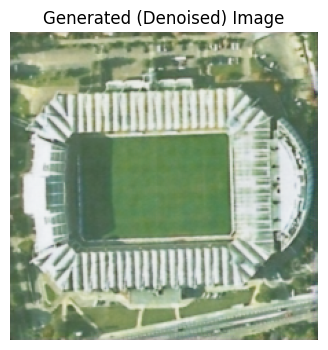

In [88]:
show_generated_image(generator,noisy.unsqueeze(dim=0),"cpu")

In [85]:
# noisy,_ = next(iter(test_dl))
noisy = read_image("/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V3/noisy/stadium_59.jpg").to(device)
noisy = noisy/255.0

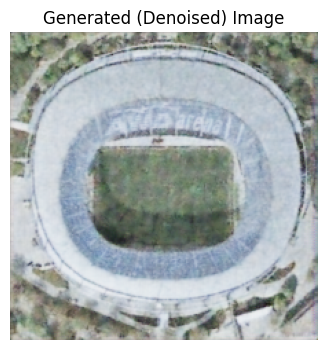

In [86]:
show_generated_image(generator,noisy.unsqueeze(dim=0),"cpu")

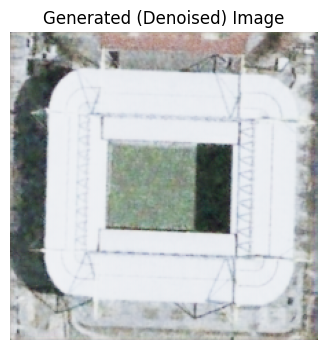

In [89]:
# noisy,_ = next(iter(test_dl))
noisy = read_image("/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V3/noisy/stadium_60.jpg").to(device)
noisy = noisy/255.0
show_generated_image(generator,noisy.unsqueeze(dim=0),"cpu")

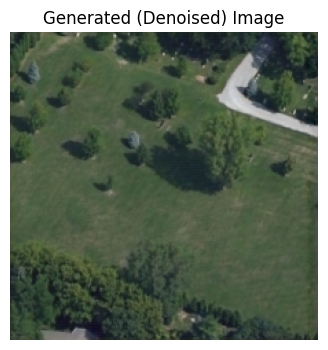

In [91]:
# noisy,_ = next(iter(test_dl))
noisy = read_image("/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V3/clean/1.jpg").to(device)
noisy = noisy/255.0
show_generated_image(generator,noisy.unsqueeze(dim=0),"cpu")

### Loss graphs

/var/folders/kt/rpgv1_gs2sz58ldgmhqpxdfc0000gn/T/ipykernel_4237/1607901981.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_data = torch.load(os.path.join(output_dir

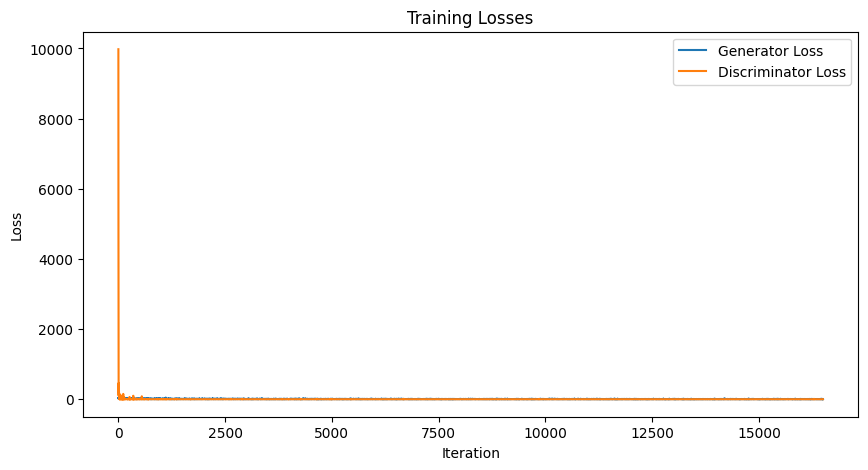

In [24]:
import torch
import matplotlib.pyplot as plt

# Load the losses (if saved)
loss_data = torch.load(os.path.join(output_dir, "losses.pt"))
disc_losses = loss_data['disc_losses']
gen_losses = loss_data['gen_losses']
iterations = loss_data['iterations']

# Plot generator and discriminator losses over iterations
plt.figure(figsize=(10, 5))
plt.plot(iterations, gen_losses, label='Generator Loss')
plt.plot(iterations, disc_losses[:len(iterations)], label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


### Testing the model

In [81]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [85]:
generator.to(device)
generator.eval()

Generator(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_block_1): DownSample(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down_block_2): DownSample(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReL

In [86]:
psnr_total = 0.0
ssim_total = 0.0
num_images = 0

In [87]:
with torch.no_grad():
    for noisy_images, real_images in test_dl:
        # Move data to the device
        noisy_images = noisy_images.to(device)
        real_images = real_images.to(device)
        
        # Generate denoised images
        fake_images = generator(noisy_images)
        
        # Convert images from [-1, 1] to [0, 1]
        fake_images = (fake_images + 1) / 2.0
        real_images = (real_images + 1) / 2.0
        
        # Move to CPU and convert to NumPy for metric calculations
        fake_images_np = fake_images.cpu().numpy()
        real_images_np = real_images.cpu().numpy()
        
        # Loop over batch and compute metrics per image
        batch_size = fake_images_np.shape[0]
        for i in range(batch_size):
            # Rearrange from (C, H, W) to (H, W, C)
            fake_img = np.transpose(fake_images_np[i], (1, 2, 0))
            real_img = np.transpose(real_images_np[i], (1, 2, 0))
            
            # Compute PSNR; set data_range=1.0 since images are in [0, 1]
            psnr_val = peak_signal_noise_ratio(real_img, fake_img, data_range=1.0)
            # Compute SSIM; use multichannel=True for color images
            ssim_val = structural_similarity(real_img, fake_img, multichannel=True, data_range=1.0, win_size=3)
            
            psnr_total += psnr_val
            ssim_total += ssim_val
            num_images += 1

In [89]:
avg_psnr = psnr_total / num_images
avg_ssim = ssim_total / num_images

print(f"Test PSNR: {avg_psnr:.2f} dB")
print(f"Test SSIM: {avg_ssim:.4f}")

Test PSNR: 33.04 dB
Test SSIM: 0.9176


In [90]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim_metric, peak_signal_noise_ratio as psnr_metric
import cv2
from tqdm import tqdm

# === Denoising Runner ===
def run_denoising(model_path, clean_dir, noisy_dir, output_dir, device='cuda'):
    os.makedirs(output_dir, exist_ok=True)

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
    ])

    inverse_transform = T.Compose([
        T.ToPILImage()
    ])

    # model = Generator().to(device)
    # model.load_state_dict(torch.load(model_path, map_location=device))
    # model.eval()
    model = torch.load(model_path).to(device)

    psnr_scores = []
    ssim_scores = []

    image_files = sorted(os.listdir(noisy_dir))
    for fname in tqdm(image_files):
        noisy_path = os.path.join(noisy_dir, fname)
        clean_path = os.path.join(clean_dir, fname.replace("_gauss", "").replace("_mult", "").replace("_rand", ""))

        if not os.path.exists(clean_path):
            print(f"Clean image not found for {fname}, skipping.")
            continue

        clean_img = Image.open(clean_path).convert("RGB")
        noisy_img = Image.open(noisy_path).convert("RGB")

        # Resize and normalize
        clean_tensor = transform(clean_img).unsqueeze(0).to(device)
        noisy_tensor = transform(noisy_img).unsqueeze(0).to(device)

        with torch.no_grad():
            denoised_tensor = model(noisy_tensor)

        # Convert tensors back to images
        clean_np = np.array(T.ToPILImage()(clean_tensor.squeeze(0).cpu()))
        noisy_np = np.array(T.ToPILImage()(noisy_tensor.squeeze(0).cpu()))
        denoised_np = np.array(inverse_transform(denoised_tensor.squeeze(0).cpu()))

        # Compute metrics
        psnr_val = psnr_metric(clean_np, denoised_np, data_range=1.0)
        ssim_val = ssim_metric(clean_np, denoised_np, multichannel=True, data_range=1.0, win_size=3)

        psnr_scores.append(psnr_val)
        ssim_scores.append(ssim_val)

        # Create a combined image
        combined = np.hstack([
            cv2.resize(clean_np, (224, 224)),
            cv2.resize(noisy_np, (224, 224)),
            cv2.resize(denoised_np, (224, 224)),
        ])
        cv2.imwrite(os.path.join(output_dir, fname), combined)

    # Report average metrics
    print(f"\nAverage PSNR: {np.mean(psnr_scores):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_scores):.4f}")

# --- Example usage ---
if __name__ == "__main__":
    run_denoising(
        model_path="/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Model/V8/gen.pth",
        clean_dir="/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset_V3/clean",
        noisy_dir="/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/dataset/Dataset10p/Gaussian",  # or multiplicative/random
        output_dir="/Users/vedanshkumar/Documents/Fun_ml/Projects/FuzzyLogicFiltering/Model/outputs",
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

/var/folders/kt/rpgv1_gs2sz58ldgmhqpxdfc0000gn/T/ipykernel_25545/2798435126.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path).to(device)
10


Average PSNR: -28.71 dB
Average SSIM: 0.6880
